### Prisma Data Analysis

Table of contents: 

  1. Importing librairies
  2. Defining functions
  3. Collecting data from file
  4. Plotting RGB
  5. Creating Pandas Geodataframe
  6. Importing Tare data


##### 1. Importing librairies

In [2]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.ops import unary_union

##### 2. Defining functions

In [11]:
def normalise(pic):
  max = pic.max()
  min = pic.min()
  new = (pic - min)/(max-min)
  return 

def create_geopandas(data_with_coord):
    columns = [f"band_{i}" for i in range(66)]
    columns.append("lat")
    columns.append("lon")
    data_with_coord_flat = data_with_coord.reshape(data_with_coord.shape[0]*data_with_coord.shape[1], 68)
    data = pd.DataFrame(data_with_coord_flat, columns=columns)
    df_all = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lon, data.lat))
    return df_all


##### 3. Collecting data from file

In [6]:
filename = "data\[62.9215 , 8.43994].he5"
data = None
with h5py.File(filename, mode='r') as f:
    data = np.array(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]["Data Fields"]['VNIR_Cube'])
    lat = np.array(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]['Geolocation Fields']['Latitude_VNIR'])
    lon = np.array(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]['Geolocation Fields']['Longitude_VNIR'])

##### 4. Plotting RGB

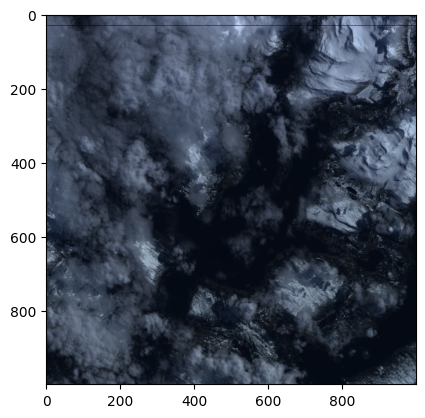

In [7]:
coord = np.array([lat,lon]).T
data_with_coord = np.zeros((1000,1000,66+2))
data_with_coord[:,:,:66] = np.transpose(data,[0,2,1])
data_with_coord[:,:,66:] = coord
RGB = np.dstack((data_with_coord[:,:,33] , data_with_coord[:,:,45] , data_with_coord[:,:,56]))
RGB = normalise(RGB)
plt.imshow(RGB)

##### 5. Creating Pandas

In [12]:
df_all = create_geopandas(data_with_coord)
df_all["seaweed"] = np.zeros(1000000)

#####   6. Importing Tare data

In [13]:
data_naturdirektoratet = gpd.read_file("data\naturdirektoratet.json")

DriverError: 'data aturdirektoratet.json' does not exist in the file system, and is not recognized as a supported dataset name.

In [81]:
seaweed = data_naturdirektoratet.copy()
seaweed= seaweed.loc[seaweed["naturtype"] == "størreTareskogforekomster"]

##### 7. Collecting training data based on lat and lon

In [112]:
#Only including the data from Naturdirektoratet which is within the prisma photo.
lon_min, lat_min, lon_max, lat_max = df_all.total_bounds
seaweed = seaweed.cx[lon_min:lon_max, lat_min:lat_max].geometry

nr_pixels = 1000
size = 1000
dlon = (lon_max-lon_min)*nr_pixels/size
dlat = (lat_max-lat_min)*nr_pixels/size
number_of_slices = int(size/nr_pixels)

for i in range(number_of_slices-1):
  lat_lower = lat_min + i*dlat
  lat_upper = lat_min + (i+1)*dlat
  for j in range(number_of_slices-1):
    lon_left = lon_min + j*dlon
    lon_right = lon_min + (j+1)*dlon
    seaweed_current = seaweed.cx[lon_left:lon_right,lat_lower:lat_upper]
    if not seaweed_current.empty:
      polygons = unary_union(seaweed_current)
      df_all_current = df_all.cx[lon_left:lon_right,lat_lower:lat_upper]
      df_all.loc[df_all_current.index, "seaweed"] = df_all_current.geometry.within(polygons)


In [113]:
df_all["seaweed"].unique()

array([0.0, True], dtype=object)

In [103]:
df_all.to_csv("df_all_[62.8147, 7. 60619]")

KeyboardInterrupt: ignored

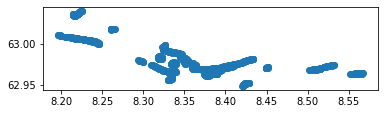

In [114]:
df_all_true = df_all[df_all["seaweed"] == True].plot()